Attribution 4.0 International (CC BY 4.0)

https://creativecommons.org/licenses/by/4.0/

Expectation: random < no prediction < generic heuristic < model-specific heuristic < ML

expect that failure depends on
* age of drive (wear)
* manufacturer, model, batch

In [1]:
import pandas
print('pandas',pandas.__version__)
import glob
import pickle
import numpy
import datetime
import time
import matplotlib.pyplot as plt

pandas 0.23.4


# no predictions

for each day, count number of drives and number of drives removed from service

* TP=0
* TN=97.45%
* FP=0
* FN=2.55%

error rate = (FP+FN)/total=2.55 (lower is better)

In [2]:
start_time=time.time()
df_np = pandas.read_csv('data_synthesized_from_csvs/failures_vs_drive_count_per_day.dat',delimiter=' ',header=None)
df_np.columns=['date in filename','number of drives removed from service','number of unique drives']
df_np['date']=df_np['date in filename'].apply(lambda x: datetime.datetime.strptime(x.split('_')[-1],'%Y-%m-%d'))
df_np.drop(['date in filename'], axis=1,inplace=True)
df_np['ratio of drives removed from service to count per day']=df_np['number of drives removed from service']/df_np['number of unique drives']
print('elapsed:',time.time()-start_time,'seconds')
df_np.shape

elapsed: 0.05575299263000488 seconds


(2092, 4)

In [3]:
df_np.head()

,number of failures,number of unique drives,date,ratio of failures to count per day
0,6,102094,2018-05-22,0.000059
1,3,100576,2018-06-13,0.000030
2,4,100064,2018-04-30,0.000040
3,6,100529,2018-06-14,0.000060
4,6,101864,2018-05-25,0.000059


In [4]:
df_np['TP drive predicted to be removed is removed']=0
df_np['TN drive expected to work continues to work']=df_np['number of unique drives']-df_np['number of failures']
df_np['FP drive predicted to be removed is not removed']=0
df_np['FN drive expected to work is removed']=df_np['number of failures']

df_np['overall error rate in %'] = 100.0*((df_np['FP drive predicted to be removed is not removed']+df_np['FN drive expected to work is removed'])/df_np['number of unique drives'])

df_np.head()

,number of failures,number of unique drives,date,ratio of failures to count per day,TP drive predicted to be removed is removed,TN drive expected to work continues to work,FP drive predicted to be removed is not removed,FN drive expected to work is removed,overall error rate in %
0,6,102094,2018-05-22,0.000059,0,102088,0,6,0.005877
1,3,100576,2018-06-13,0.000030,0,100573,0,3,0.002983
2,4,100064,2018-04-30,0.000040,0,100060,0,4,0.003997
3,6,100529,2018-06-14,0.000060,0,100523,0,6,0.005968
4,6,101864,2018-05-25,0.000059,0,101858,0,6,0.005890


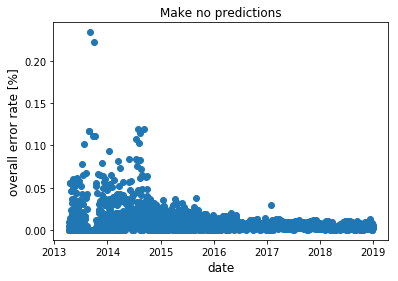

In [5]:
plt.plot_date(x=df_np['date'],y=df_np['overall error rate in %'])
plt.title('Make no predictions',fontsize=12)
plt.xlabel('date',fontsize=12)
plt.ylabel('overall error rate [%]',fontsize=12);

# random prediction

"in the next three days, this drive will be removed"
* drive could be removed tomorrow (today+1)
* drive could be removed today+2
* drive could be removed today+3


for each day, get list of drives

from that list, select `(random_failure_rate)*len(list_of_drives)` to be removed.

* TP=0
* TN=92.5
* FP=4.9
* FN=2.57

overall error rate = (FP+FN)/total = 7.5


In [6]:
start_time=time.time()
df_rp = pandas.read_csv('data_synthesized_from_csvs/all_drives_no_smart.dat',header=None,parse_dates=[0])
print('elapsed:',time.time()-start_time,'seconds')

elapsed: 149.6175844669342 seconds


In [7]:
df_rp.shape

(126827076, 4)

In [8]:
df_rp.dtypes

0    datetime64[ns]
1            object
2            object
3             int64
dtype: object

In [9]:
start_time=time.time()
df_rp.columns=['date','drive serial','drive model','drive removed from service']
# the following two steps are unnecessary due to the use of parse_dates
#df_rp['date']=df_rp['date in filename'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))
#df_rp.drop(['date in filename'], axis=1,inplace=True)
print('elapsed:',time.time()-start_time,'seconds')

elapsed: 0.0011038780212402344 seconds


In [10]:
daily_failure_rate=int(10.0/100000.0)

In [11]:
list_of_dates = list(df_rp['date'].unique())
list_of_dates.sort()
len(list_of_dates)

2089

In [12]:
len(list_of_dates)/365.25

5.71937029431896

In [13]:
df_rand_by_date = pandas.DataFrame.from_dict({'dates':list_of_dates,
                                              'TP drive predicted to be removed is removed':numpy.nan,
                                              'TN drive expected to work continues to work':numpy.nan,
                                              'FP drive predicted to be removed is not removed':numpy.nan,
                                              'FN drive expected to work is removed':numpy.nan,})
df_rand_by_date=df_rand_by_date.set_index('dates')
df_rand_by_date.head()

,TP drive predicted to be removed is removed,TN drive expected to work continues to work,FP drive predicted to be removed is not removed,FN drive expected to work is removed
dates,,,,
2013-04-10,NaN,NaN,NaN,NaN
2013-04-11,NaN,NaN,NaN,NaN
2013-04-12,NaN,NaN,NaN,NaN
2013-04-13,NaN,NaN,NaN,NaN
2013-04-14,NaN,NaN,NaN,NaN


In [14]:
start_time=time.time()

prediction_window = 3 # "3" means given measurements today, look three days in advance
days=[]
failed_drives={}
for indx in range(len(list_of_dates)-prediction_window):
    print('indx=',indx)
    # create list of days for this window
    for window_indx in range(prediction_window+1):
        print('window index=',window_indx)
        # 0 = today; 1 = tomorrow, 2 = day-after-tomorrow, etc
        try:
            print(list_of_dates[indx+window_indx])
            days[window_indx] = list_of_dates[indx+window_indx]
        except IndexError:
            print('end of scan:',len(list_of_dates),'indx=',indx)
            break
    print(days)
    # "prediction" step: select a random set of drives from today that are going to fail in the next N days
    print('today:',days[0])
    print(df_rp[df_rp['date']==days[0]])
    
    drives_predicted_to_fail = set(df_rp[df_rp['date']==days[0]].sample(n=daily_failure_rate)['drive serial'])

    # which drives actually failed the next day?
    failed_drives=[]
    for next_days_indx in range(1,prediction_window+1):
        for serl in list(df_rp[df_rp['date']==days[next_days_indx] & df_rp['failure']==1]['drive serial']):
            failed_drives.append(serl)
    failed_drives = set(failed_drives)
    
    df_rand_by_date.at[days[0],'TP drive predicted to be removed is removed']=len(drives_predicted_to_fail.intersection(failed_drives))
    df_rand_by_date.at[days[0],'TN drive expected to work continues to work']=0
    df_rand_by_date.at[days[0],'FP drive predicted to be removed is not removed']=0
    df_rand_by_date.at[days[0],'FN drive expected to work is removed']=0

print('elapsed:',time.time()-start_time,'seconds')

indx= 0
window index= 0
2013-04-10T00:00:00.000000000
end of scan: 2089 indx= 0
[]


IndexError: list index out of range

In [ ]:
list_of_dates[0]

# simple heuristic: measure exceeds threshold 

threshold_for_raw5=1000

prediction_window_in_days=3

for each drive, if raw5>1000, then predict that in the next 3 days the drive will fail

tp_drive_predicted_to_be_removed_is_removed=0
tn_drive_expected_to_work_continues_to_work=0
fp_drive_predicted_to_be_removed_is_not_removed=0
fn_drive_expected_to_work_is_removed=0


* TP=0.13
* TN=97.3
* FP=0.039
* FN=2.49

overall error rate = 2.5


In [ ]:

tp_drive_predicted_to_be_removed_is_removed=0
tn_drive_expected_to_work_continues_to_work=0
fp_drive_predicted_to_be_removed_is_not_removed=0
fn_drive_expected_to_work_is_removed=0